In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping

plt.style.use('seaborn-darkgrid')

Using TensorFlow backend.


In [3]:
COVID_DF = pd.read_csv('COVID_AllData.csv', index_col = 0)
COVID_DF.head()

,State,cases,deaths,AGI Total,AGI Top 1 Percent,AGI Top 5 Percent,AGI Top 10 Percent,AGI Top 25 Percent,AGI Top 50 Percent,AGI Top 75 Percent,...,Social Scientists 2018,Social Scientists 2018 (Percent),Technical Workers 2018,Technical Workers 2018 (Percent),Public School Expenditure 2016(Thousands),State GDP(Millions),School Expenditures per State GDP(Percent),Student Enrollment,School Expenditures per Student Enrollment(Percent),Public School Salary 2018(Dollars)
0,Alabama,387786,14345,119662909,18553159,35924229,49537638,76667112,101687773,114405941,...,3195.000000,0.170005,25768.461538,1.377782,6885677.0,203398.0,3.385322,743789.0,9257.567670,50568.0
1,Alaska,18316,367,23969001,2848087,6184956,8915998,14554105,20064361,22927860,...,1090.000000,0.345757,6370.000000,2.020619,2319662.0,49429.0,4.692917,132477.0,17509.922477,69682.0
2,Arizona,426614,18857,197753744,33609317,63073164,85351788,128616004,168531690,189378565,...,7870.000000,0.282127,40286.923077,1.608712,8551673.0,311397.0,2.746228,1109040.0,7710.878778,48723.0
3,Arkansas,161569,3301,74634888,16319991,26475276,34256878,49689104,64088761,71584342,...,2426.923077,0.209530,11790.000000,0.974284,4872214.0,120090.0,4.057135,492132.0,9900.217828,50544.0
4,California,2664110,102387,1549284943,356240355,600859502,772738760,1086299917,1360947743,1497300869,...,50350.000000,0.296043,266500.000000,1.566938,72003129.0,2663396.0,2.703433,6305347.0,11419.376126,80680.0


In [4]:
columns = [col for col in COVID_DF.columns if '(Percent)' not in col][3:]
columns

['AGI Total',
 'AGI Top 1 Percent',
 'AGI Top 5 Percent',
 'AGI Top 10 Percent',
 'AGI Top 25 Percent',
 'AGI Top 50 Percent',
 'AGI Top 75 Percent',
 'Total Population',
 'Total population_Male',
 'Total population_Female',
 'Under 5 years',
 '5 to 9 years',
 '10 to 14 years',
 '15 to 19 years',
 '20 to 24 years',
 '25 to 34 years',
 '35 to 44 years',
 '45 to 54 years',
 '55 to 59 years',
 '60 to 64 years',
 '65 to 74 years',
 '75 to 84 years',
 '85 years and over',
 'RACE_Total population',
 'White',
 'Black or African American',
 'American Indian and Alaska Native',
 'Asian',
 'Native Hawaiian and Other Pacific Islander',
 'Total population_HISPANIC OR LATINO',
 '4th 2015 Math',
 '4th 2015 Science',
 '8th 2015 Math',
 '8th 2015 Science',
 'Labor Force w/ Bachelor 2018',
 'Labor Force Participants 2018',
 'Percent of Labor Force w/ Bachelor 2018',
 'Doctorate From Doc Inst 2018',
 'Doctorate From Bach Inst 2018',
 'Total Doctorate Degrees 2018',
 'Less Than HS Diploma 14-18',
 'HS Di

## Deep Learning Model

In [5]:
test_len = int(0.25 * len(COVID_DF))
train_len = len(COVID_DF) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = COVID_DF[:train_len]
test = COVID_DF[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 96)
Test Set Shape: (12, 96)


### Keras Regressor

In [6]:
features_list = columns
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

def build_regressor():
    regressor = Sequential()
    regressor.add(Dense(units = 200, activation = 'relu', input_dim = 80))
    regressor.add(Dense(units = 200, activation = 'relu'))
    regressor.add(Dense(units = 200, activation = 'relu'))
    regressor.add(Dense(units = 200, activation = 'relu'))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae', 'accuracy'])
    return regressor

KerasRegModel = KerasRegressor(build_fn = build_regressor, batch_size = 32, epochs = 100)
early_stopping_monitor = EarlyStopping(patience = 5)
KerasRegModel.fit(X_train_scaled, y_train_scaled, callbacks = [early_stopping_monitor])

train_predictions_scaled = KerasRegModel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = KerasRegModel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

Epoch 1/100
39/39 [==============================] - 0s 10ms/step - loss: 1.6049 - mae: 0.5346 - accuracy: 0.0000e+00
Epoch 2/100
39/39 [==============================] - 0s 206us/step - loss: 0.6927 - mae: 0.3548 - accuracy: 0.0000e+00
Epoch 3/100
39/39 [==============================] - 0s 204us/step - loss: 0.5879 - mae: 0.3831 - accuracy: 0.0000e+00
Epoch 4/100
39/39 [==============================] - 0s 205us/step - loss: 0.4694 - mae: 0.2628 - accuracy: 0.0000e+00
Epoch 5/100
39/39 [==============================] - 0s 205us/step - loss: 0.4101 - mae: 0.2701 - accuracy: 0.0000e+00
Epoch 6/100
39/39 [==============================] - 0s 410us/step - loss: 0.3075 - mae: 0.2505 - accuracy: 0.0000e+00
Epoch 7/100
39/39 [==============================] - 0s 410us/step - loss: 0.2111 - mae: 0.2180 - accuracy: 0.0000e+00
Epoch 8/100
39/39 [==============================] - 0s 205us/step - loss: 0.1302 - mae: 0.2008 - accuracy: 0.0000e+00
Epoch 9/100
39/39 [==============================

c:\python38\lib\site-packages\keras\callbacks\callbacks.py:843: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,accuracy
  warnings.warn(


Epoch 14/100
39/39 [==============================] - 0s 52us/step - loss: 0.0139 - mae: 0.0748 - accuracy: 0.0000e+00
Epoch 15/100
39/39 [==============================] - 0s 421us/step - loss: 0.0103 - mae: 0.0782 - accuracy: 0.0000e+00
Epoch 16/100
39/39 [==============================] - 0s 206us/step - loss: 0.0224 - mae: 0.0958 - accuracy: 0.0000e+00
Epoch 17/100
39/39 [==============================] - 0s 205us/step - loss: 0.0122 - mae: 0.0696 - accuracy: 0.0000e+00
Epoch 18/100
39/39 [==============================] - 0s 205us/step - loss: 0.0130 - mae: 0.0766 - accuracy: 0.0000e+00
Epoch 19/100
39/39 [==============================] - 0s 204us/step - loss: 0.0064 - mae: 0.0496 - accuracy: 0.0000e+00
Epoch 20/100
39/39 [==============================] - 0s 189us/step - loss: 0.0088 - mae: 0.0548 - accuracy: 0.0000e+00
Epoch 21/100
39/39 [==============================] - 0s 284us/step - loss: 0.0649 - mae: 0.1244 - accuracy: 0.0000e+00
Epoch 22/100
39/39 [=====================

39/39 [==============================] - 0s 206us/step - loss: 1.0054e-04 - mae: 0.0051 - accuracy: 0.0000e+00
Epoch 82/100
39/39 [==============================] - 0s 204us/step - loss: 5.1388e-05 - mae: 0.0054 - accuracy: 0.0000e+00
Epoch 83/100
39/39 [==============================] - 0s 0us/step - loss: 4.2854e-05 - mae: 0.0053 - accuracy: 0.0000e+00
Epoch 84/100
39/39 [==============================] - 0s 205us/step - loss: 2.9173e-05 - mae: 0.0039 - accuracy: 0.0000e+00
Epoch 85/100
39/39 [==============================] - 0s 179us/step - loss: 3.5678e-05 - mae: 0.0044 - accuracy: 0.0000e+00
Epoch 86/100
39/39 [==============================] - 0s 205us/step - loss: 5.1474e-05 - mae: 0.0056 - accuracy: 0.0000e+00
Epoch 87/100
39/39 [==============================] - 0s 205us/step - loss: 2.0818e-05 - mae: 0.0034 - accuracy: 0.0000e+00
Epoch 88/100
39/39 [==============================] - 0s 205us/step - loss: 2.9428e-05 - mae: 0.0046 - accuracy: 0.0000e+00
Epoch 89/100
39/39 [===

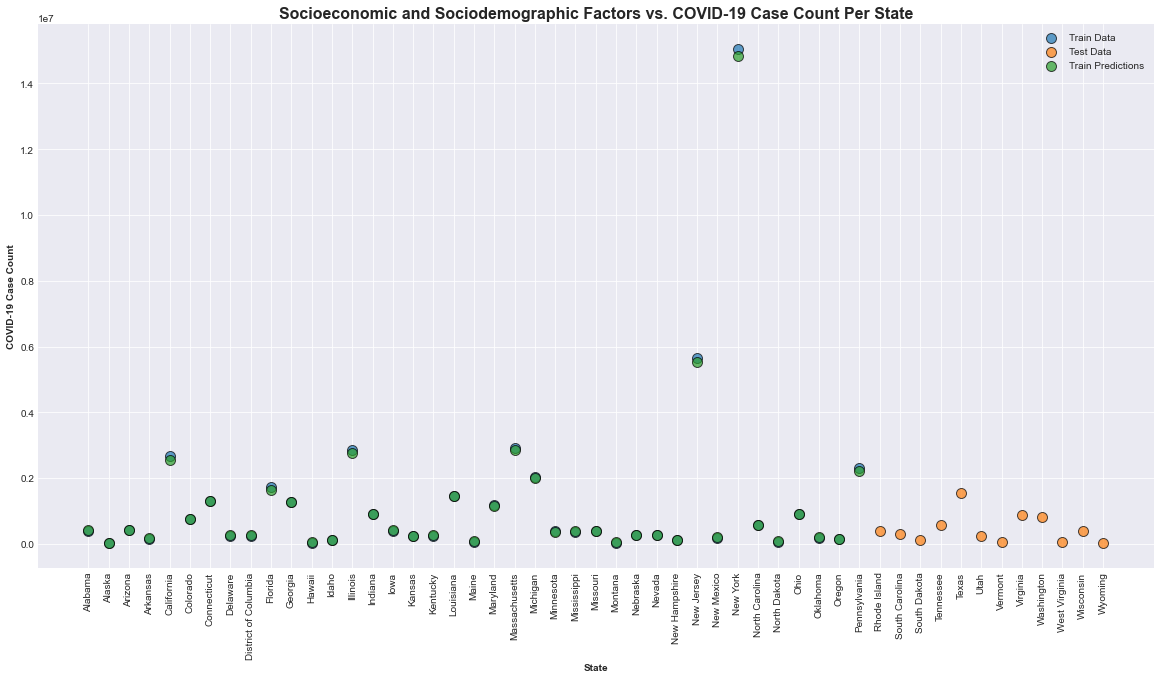

In [7]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Socioeconomic and Sociodemographic Factors vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

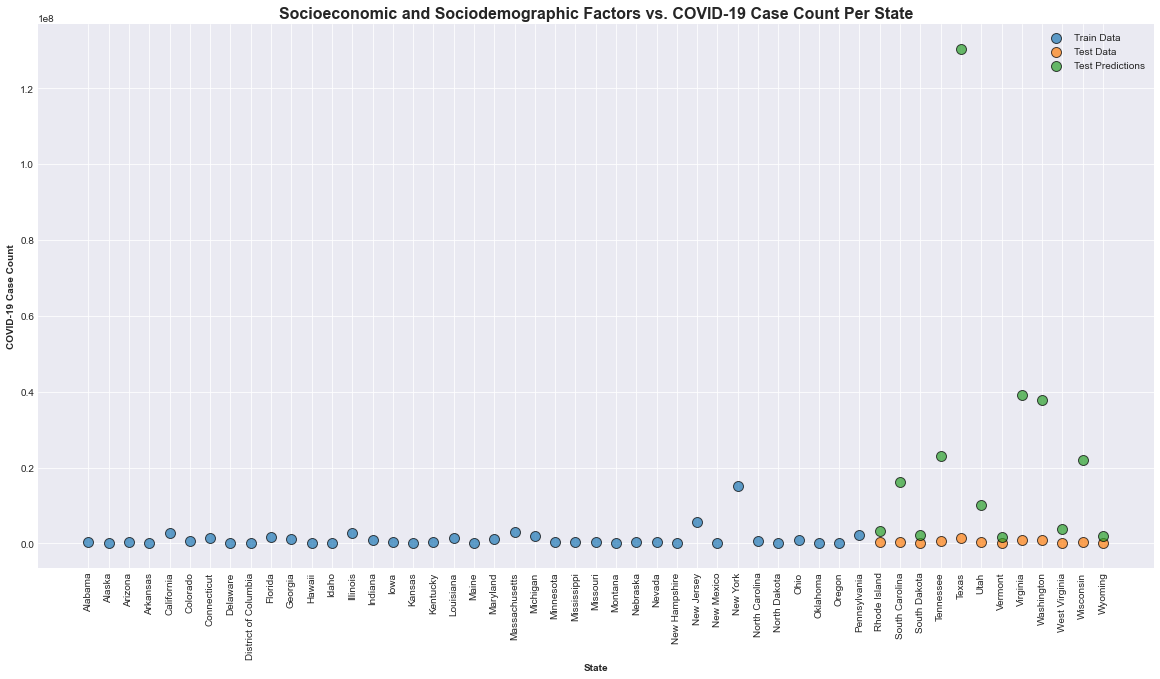

In [8]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Socioeconomic and Sociodemographic Factors vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

#### Tuning Keras Regressor

### LSTM

In [20]:
features_list = columns
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

X_train_scaled = np.array(X_train_scaled).reshape(1, X_train_scaled.shape[0], X_train_scaled.shape[1])
X_test_scaled = np.array(X_test_scaled).reshape(1, X_test_scaled.shape[0], X_test_scaled.shape[1])

LSTMmodel = Sequential()
LSTMmodel.add(LSTM(10, input_shape=(X_train_scaled.shape[0], X_train_scaled.shape[1])))
LSTMmodel.add(Dense(1))
LSTMmodel.compile(loss='mean_squared_error', optimizer='adam')
LSTMmodel.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=1, verbose=1, shuffle=False)

train_predictions_scaled = LSTMmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = LSTMmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

Train_MAE = mean_absolute_error(y_train, train_predictions)
Train_MSE = mean_squared_error(y_train, train_predictions)
Train_RMS = sqrt(mean_squared_error(y_train, train_predictions))
Train_R2Score = r2_score(y_train, train_predictions)

Test_MAE = mean_absolute_error(y_test, test_predictions)
Test_MSE = mean_squared_error(y_test, test_predictions)
Test_RMS = sqrt(mean_squared_error(y_test, test_predictions))
Test_R2Score = r2_score(y_test, test_predictions)

print('Train MAE Value:', Train_MAE)
print('Train MSE Value:', Train_MSE)
print('Train RMS Value:', Train_RMS)
print('Train R2 Score:', Train_R2Score)
print('\n')

print('Test MAE Value:', Test_MAE)
print('Test MSE Value:', Test_MSE)
print('Test RMS Value:', Test_RMS)
print('Test R2 Score:', Test_R2Score)

ValueError: Error when checking input: expected lstm_6_input to have shape (1, 39) but got array with shape (39, 80)

In [11]:
X_train_scaled.shape[0]

1

In [12]:
X_train_scaled.shape[1]

39

In [13]:
X_train_scaled.shape[2]

80

In [15]:
X_train_scaled.shape

(1, 39, 80)